In [2]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import warnings
warnings.filterwarnings('ignore')
print('TensorFlow version: ', tf.__version__)

os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
gpus = tf.config.list_physical_devices('GPU')
if len(gpus) <= 1:
    strategy = tf.distribute.OneDeviceStrategy(device='/gpu:0')
else:
    strategy = tf.dis

TensorFlow version:  2.17.0


In [ ]:
!pip install -q git+https://github.com/qubvel/classification_models.git

from classification_models.tfkeras import Classifiers
resnet18, preprocess_input = Classifiers.get('resnet18')

In [4]:
def build_model():
    n_classes = 9

    inp = tf.keras.layers.Input(shape=(256,256,3))
    res_model = resnet18(include_top=False, weights='imagenet', input_shape=(256,256,3))
    res_model._name = 'resnet18'

    for layer in res_model.layers[:len(res_model.layers)//10]:
        layer.trainable = False

    x = res_model(inp)
    last_conv_layer = x
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    output = tf.keras.layers.Dense(n_classes, activation='softmax', dtype='float32')(x)

    model = tf.keras.Model(inputs=inp, outputs=output, name='hybrid')
    grad_model = tf.keras.Model(inputs=inp, outputs=[last_conv_layer, output])

    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.15)
    opt = tf.keras.optimizers.Adam(learning_rate=1e-3)

    model.compile(loss=loss, optimizer=opt, metrics=['accuracy'])

    return model, grad_model

model, grad_model = build_model()

In [5]:
def get_gradcam(grad_model, img_array, pred_index=None):
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])

        pred_index = tf.cast(pred_index, dtype=tf.int32)
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    
    return heatmap.numpy()

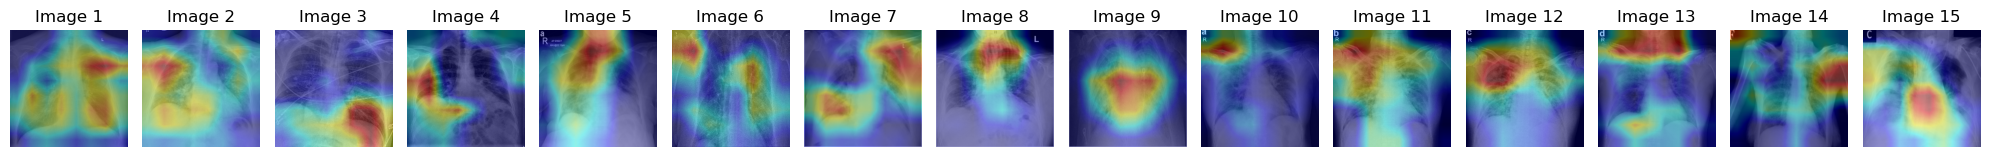

In [6]:
all_index = np.array([
r"C:\Users\Sese\machinelearning\Lung_Image_AI\data\rapid-cxr-dataset\lung_diseases\Covid\COVID19(2).jpg",
r"C:\Users\Sese\machinelearning\Lung_Image_AI\data\rapid-cxr-dataset\lung_diseases\Covid\COVID19(3).jpg",
r"C:\Users\Sese\machinelearning\Lung_Image_AI\data\rapid-cxr-dataset\lung_diseases\Covid\COVID19(4).jpg",
r"C:\Users\Sese\machinelearning\Lung_Image_AI\data\rapid-cxr-dataset\lung_diseases\Covid\COVID19(5).jpg",
r"C:\Users\Sese\machinelearning\Lung_Image_AI\data\rapid-cxr-dataset\lung_diseases\Covid\COVID19(6).jpg",
r"C:\Users\Sese\machinelearning\Lung_Image_AI\data\rapid-cxr-dataset\lung_diseases\Covid\COVID19(8).jpg",
r"C:\Users\Sese\machinelearning\Lung_Image_AI\data\rapid-cxr-dataset\lung_diseases\Covid\COVID19(9).jpg",
r"C:\Users\Sese\machinelearning\Lung_Image_AI\data\rapid-cxr-dataset\lung_diseases\Covid\COVID19(10).jpg",
r"C:\Users\Sese\machinelearning\Lung_Image_AI\data\rapid-cxr-dataset\lung_diseases\Covid\COVID19(11).jpg",
r"C:\Users\Sese\machinelearning\Lung_Image_AI\data\rapid-cxr-dataset\lung_diseases\Covid\COVID19(12).jpg",
r"C:\Users\Sese\machinelearning\Lung_Image_AI\data\rapid-cxr-dataset\lung_diseases\Covid\COVID19(13).jpg",
r"C:\Users\Sese\machinelearning\Lung_Image_AI\data\rapid-cxr-dataset\lung_diseases\Covid\COVID19(14).jpg",
r"C:\Users\Sese\machinelearning\Lung_Image_AI\data\rapid-cxr-dataset\lung_diseases\Covid\COVID19(15).jpg",
r"C:\Users\Sese\machinelearning\Lung_Image_AI\data\rapid-cxr-dataset\lung_diseases\Covid\COVID19(16).jpg",
r"C:\Users\Sese\machinelearning\Lung_Image_AI\data\rapid-cxr-dataset\lung_diseases\Covid\COVID19(17).jpg"])

X_test = np.array([preprocess_input(cv2.resize(cv2.imread(path), (256, 256))) for path in all_index])


plt.figure(figsize=(20, 8))
for idx, img_path in enumerate(all_index):
    x = X_test[idx].reshape(1, 256, 256, 3)

    heatmap = get_gradcam(grad_model, x)

    img = X_test[idx]
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    gradcam = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

    plt.subplot(1, 15, idx + 1)
    plt.imshow(gradcam)
    plt.title(f"Image {idx + 1}")
    plt.axis('off')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


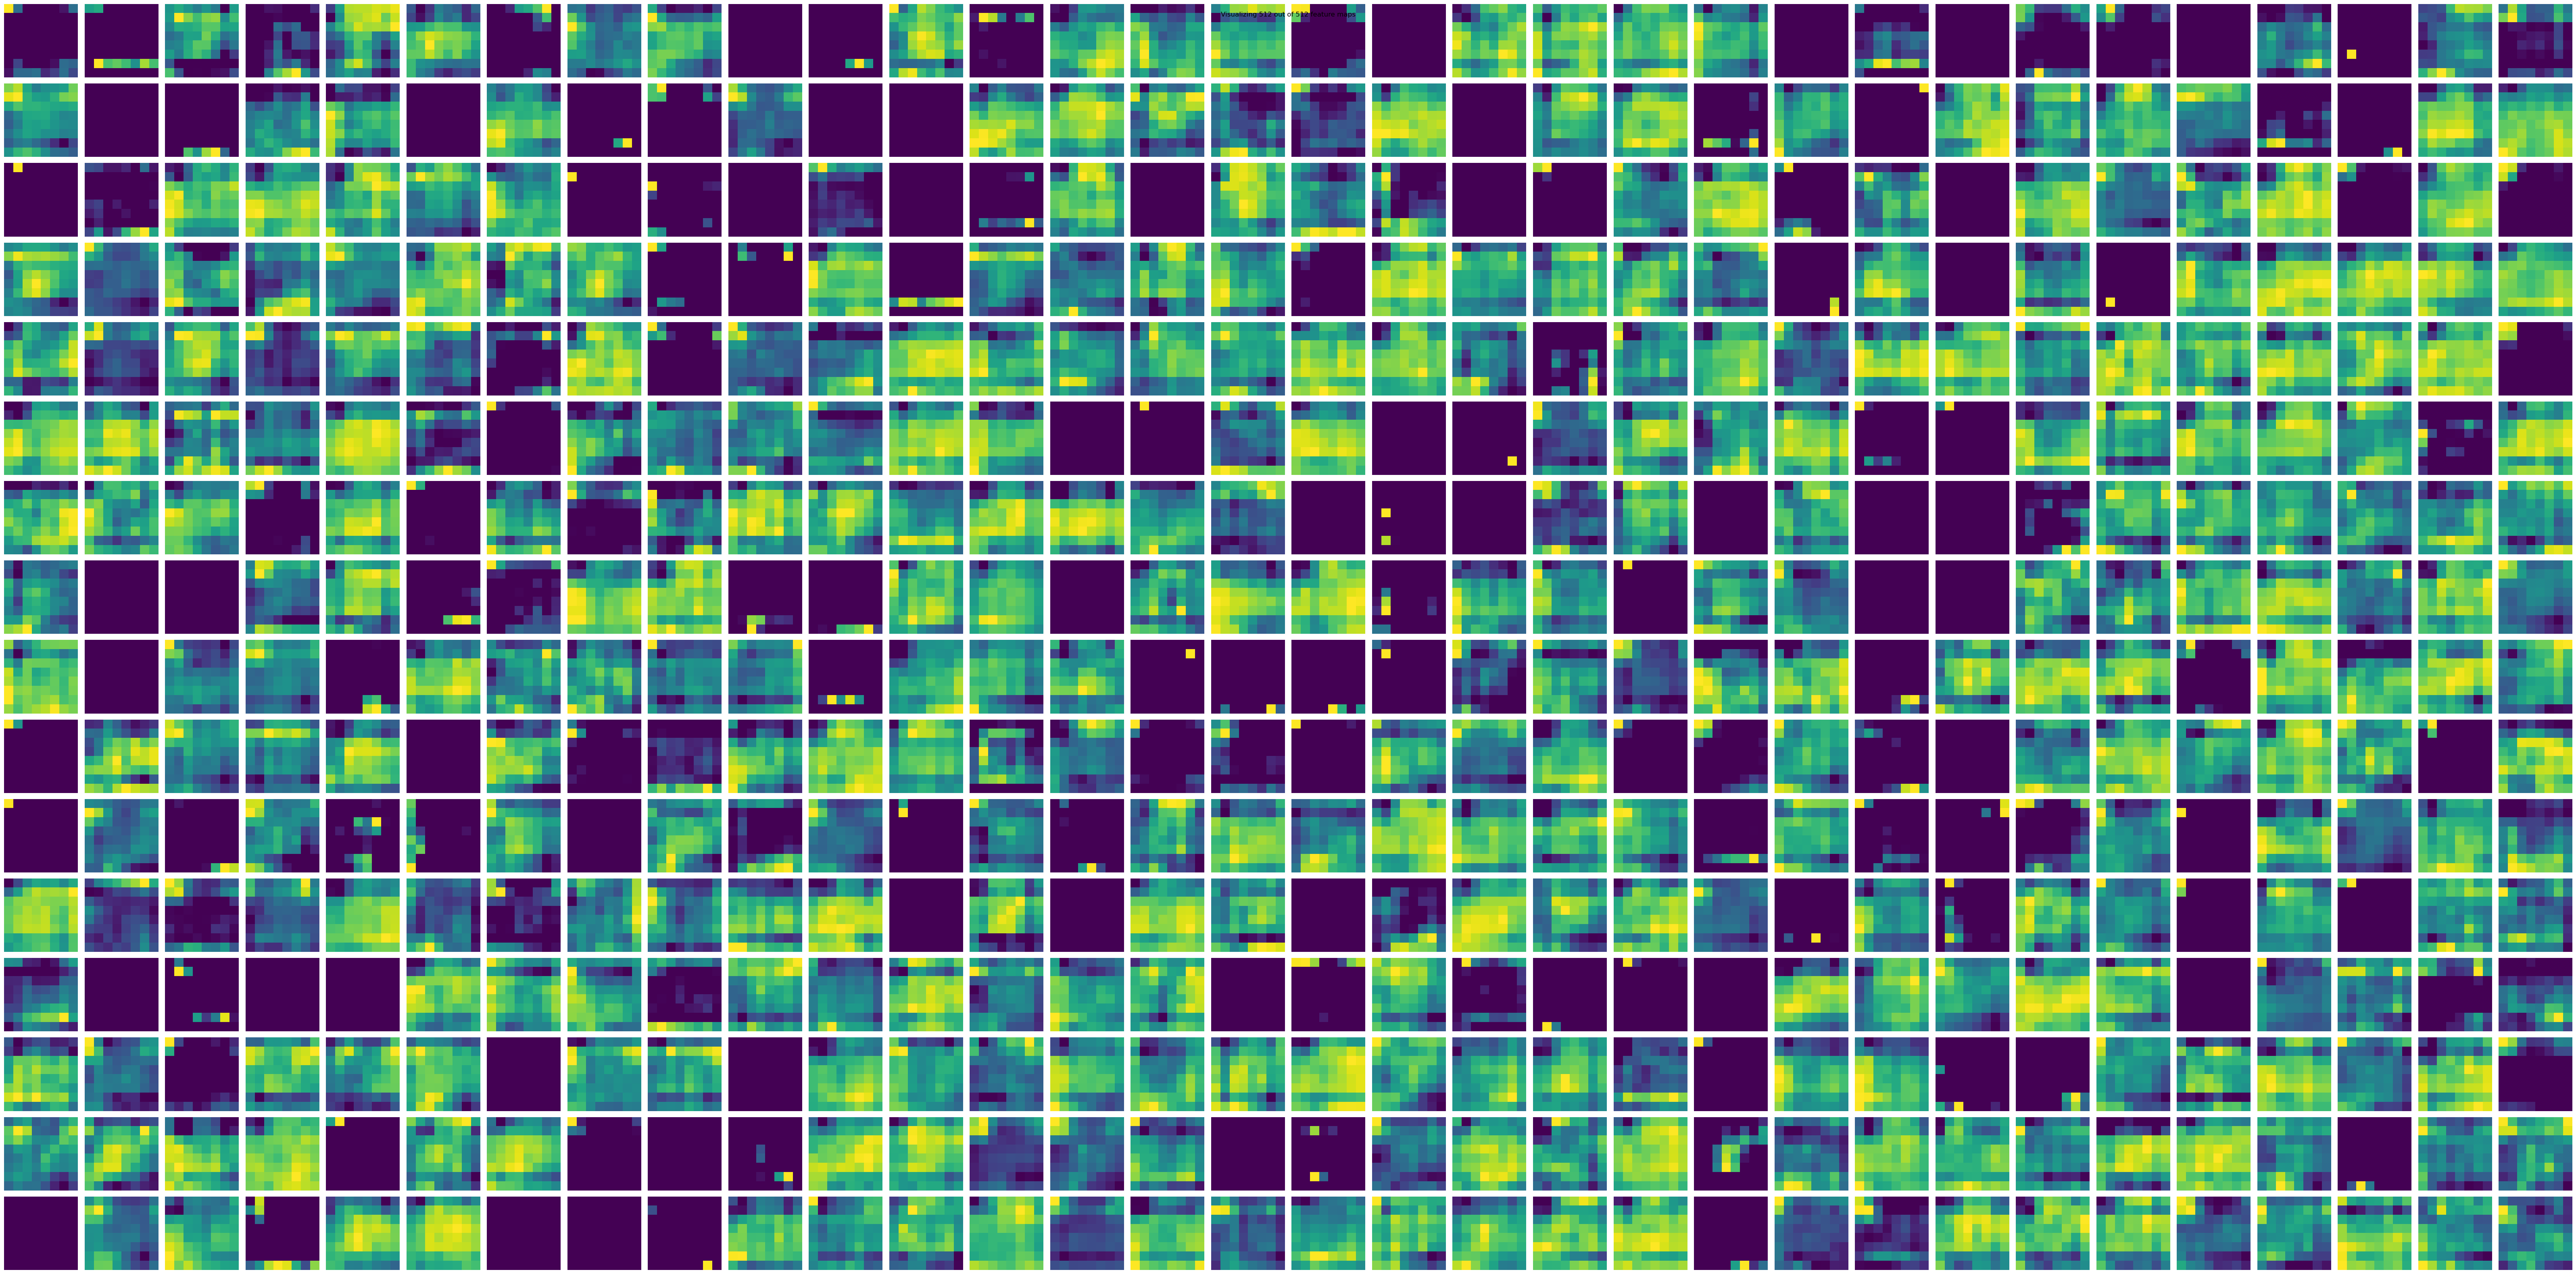

In [7]:
def visualize_feature_maps(grad_model, image_path, num_features=64, rows=8):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(256, 256))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    feature_maps, _ = grad_model.predict(img_array)
    num_features = min(num_features, feature_maps.shape[-1])
    
    cols = num_features // rows
    if num_features % rows != 0:
        cols += 1

    fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    for i, ax in enumerate(axes.flat):
        if i < num_features:
            ax.imshow(feature_maps[0, :, :, i], cmap='viridis')
        ax.axis('off')
    
    plt.suptitle(f"Visualizing {num_features} out of 512 feature maps")
    plt.tight_layout()
    plt.show()

model, grad_model = build_model()
model.load_weights('ResNet_f0.weights.h5') 

visualize_feature_maps(grad_model, r"C:\Users\Sese\machinelearning\Lung_Image_AI\data\rapid-cxr-dataset\lung_diseases\Covid\COVID19(8).jpg", num_features=512, rows=16)